In [1]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import ipywidgets as widgets
import logging
logging.basicConfig(level=logging.INFO)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lane_detector import CameraCalibration
from lane_detector import PerspectiveTransformation

cc = CameraCalibration(params_load_path='../data/camera_cal/output_params.json')
mtx, dist = cc.get_camera_params()
pp = PerspectiveTransformation()

INFO:CameraUtils:Camera params loaded and ready to use


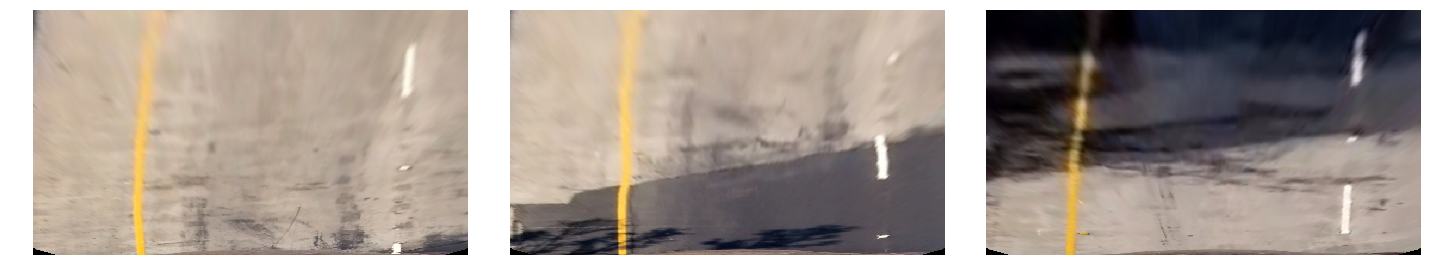

In [12]:
distorted_images = [mpimg.imread(i) for i in ['../data/test_images/test1.jpg',
                                              '../data/test_images/test4.jpg',
                                              '../data/test_images/test5.jpg',]]

WARPED_IMG_SHAPE = pp.get_destination_image_size()[::-1]
UNWARPED_IMG_SHAPE = (1280, 720) 

corrected_images = [cc.undistort_image(i) for i in distorted_images]
warped_images = [pp.warp_image(i, WARPED_IMG_SHAPE) for i in corrected_images]


f, axes = plt.subplots(1, len(warped_images), figsize=(20,10))
f.tight_layout()

for i in range(len(warped_images)):
    axes[i].axis('off')
    axes[i].imshow(warped_images[i])

In [3]:
def colorspace_visualizer(image, convertTo=cv2.COLOR_RGB2GRAY):
    converted = cv2.cvtColor(image, convertTo)
    channels = 1 if len(converted.shape) == 2 else 3
    
    if channels == 1:
        plt.imshow(converted)
    else:
        f, axes = plt.subplots(1, channels, figsize=(20,10))
        f.tight_layout()
        for i in range(channels):
            axes[i].axis('off')
            axes[i].set_title('Channel {i}'.format(i=i), fontsize=20)
            axes[i].imshow(converted[:,:,i], cmap='gray')

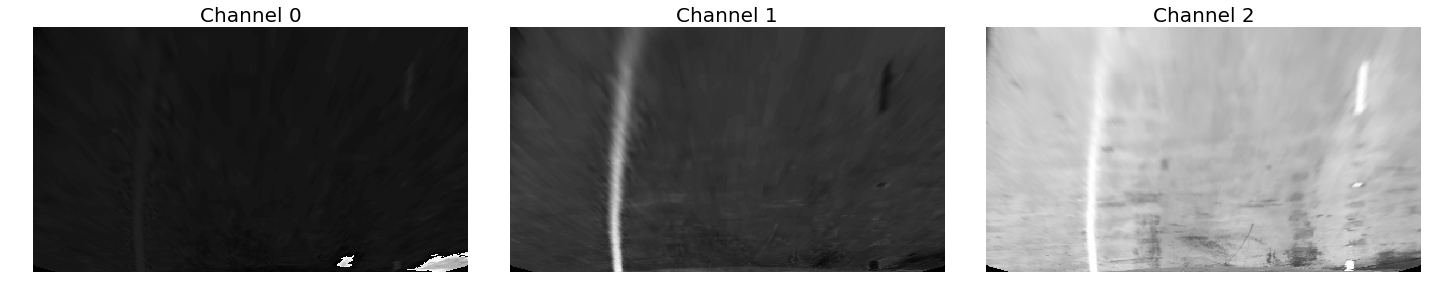

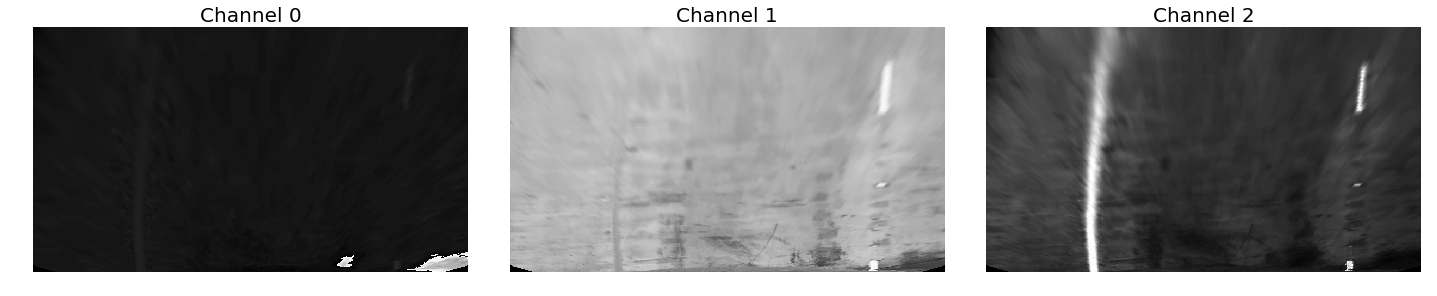

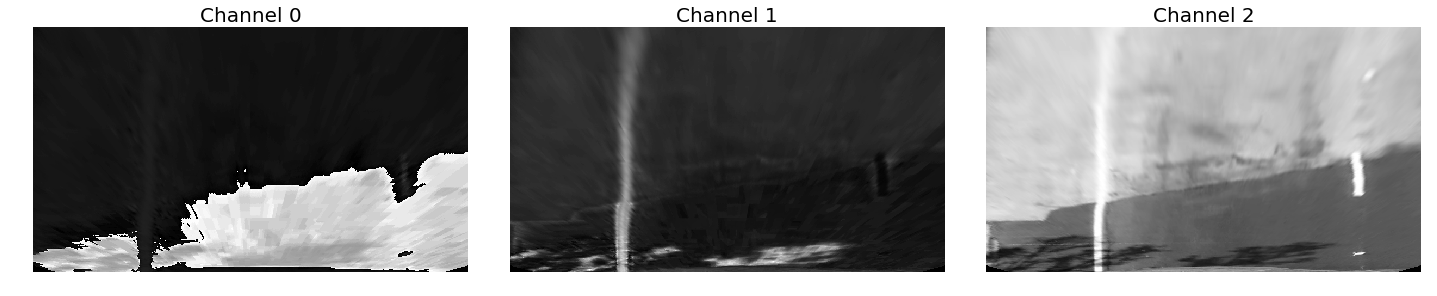

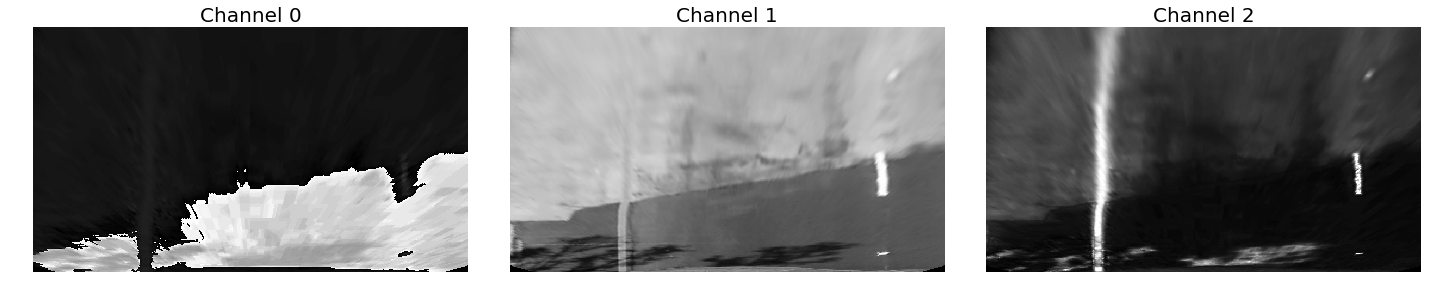

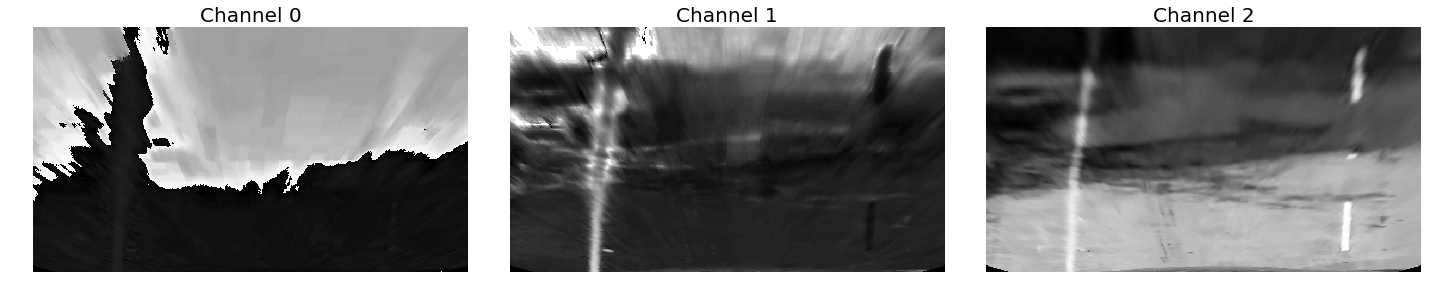

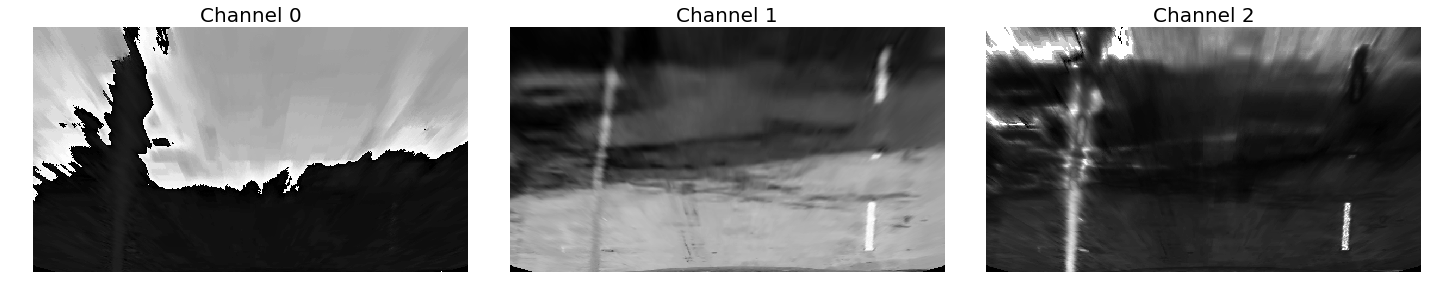

In [4]:
for i in warped_images:
    colorspace_visualizer(i, cv2.COLOR_RGB2HSV)
    colorspace_visualizer(i, cv2.COLOR_RGB2HLS)

In [5]:
def threshold_image(image, min=0, max=255):
    ''' Take a single channel image & threshold based on min & max values'''
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                    cv2.THRESH_BINARY, 11, 3)
    
def combine_s_v(image, thresh_min=125, thresh_max=255):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    #     s_channel_2 = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    combined = np.mean(np.stack((s_channel, v_channel, v_channel), axis=2), 2)
    combined = cv2.inRange(combined, thresh_min, thresh_max)
    return combined


s_v_slider = widgets.IntRangeSlider(value=[165, 255], min=0, max=255, step=1,
                                    description='Threshold S & V:', continuous_update=False,
                                    orientation='horizontal', readout=True, readout_format='d')
display(s_v_slider)


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


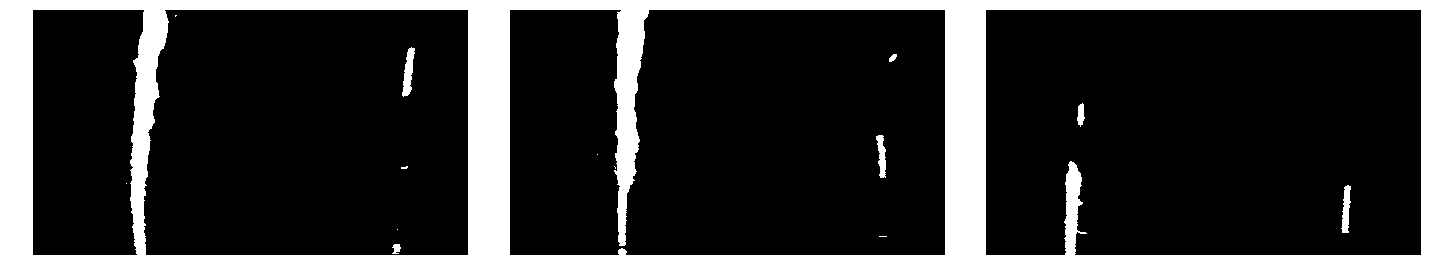

In [6]:
# bin_imgs = [threshold_image(cv2.cvtColor(i, cv2.COLOR_RGB2HSV)[:,:,2]) for i in warped_images]
combined_imgs = bin_imgs = [combine_s_v(i, s_v_slider.value[0], 
                                        s_v_slider.value[1]) for i in warped_images]

f, axes = plt.subplots(1, len(warped_images), figsize=(20,10))
f.tight_layout()
for i in range(len(warped_images)):
    axes[i].axis('off')
    axes[i].imshow(combined_imgs[i], cmap='gray')

In [7]:
# Picking S & V Channels for color thresholding since they 
# seem to pick out the white and yellow lines best
small_kernel = np.ones((3,3), np.uint8)
big_kernel = np.ones((9,9), np.uint8)

def get_binary_image(image, min_s=0, max_s=255, min_v=0, max_v=255,  min_l=0, max_l=255):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2] # get the S channel from HLS
    l_channel = hls[:,:,1] # L picks out white lines better
    v_channel = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,2] # get the V channel from HSV
   
    masked_s = cv2.inRange(s_channel, min_s, max_s)
    masked_v = cv2.inRange(v_channel, min_v, max_v)
    masked_l = cv2.inRange(l_channel, min_l, max_l)
    
#   masked_s = cv2.dilate(masked_s, kernel, iterations=2)
#     masked_l = cv2.dilate(masked_l, kernel, iterations=1)
    masked_v = cv2.morphologyEx(masked_v, cv2.MORPH_CLOSE, small_kernel)
    
    final_mask = cv2.bitwise_and(cv2.bitwise_or(masked_s, masked_l), masked_v)
    
    f, axes = plt.subplots(1, 3, figsize=(20,10))
    f.tight_layout()
    for i, img in enumerate([masked_s, masked_v, masked_l]):
        axes[i].axis('off')
        axes[i].set_title(' Image {i}'.format(i=i), fontsize=20)
        axes[i].imshow(img, cmap='gray')
    return final_mask

In [8]:
S_Min_Max = widgets.IntRangeSlider(value=[165, 255], min=0, max=255, step=1,
                                    description='S Min Max:', continuous_update=False,
                                    orientation='horizontal', readout=True, readout_format='d')

V_Min_Max = widgets.IntRangeSlider(value=[200, 255], min=0, max=255, step=1,
                                    description='V Min Max:', continuous_update=False,
                                    orientation='horizontal', readout=True, readout_format='d')

L_Min_Max = widgets.IntRangeSlider(value=[190, 255], min=0, max=255, step=1,
                                    description='L Min Max:', continuous_update=False,
                                    orientation='horizontal', readout=True, readout_format='d')

container = widgets.VBox([S_Min_Max, V_Min_Max, L_Min_Max])
display(container)


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


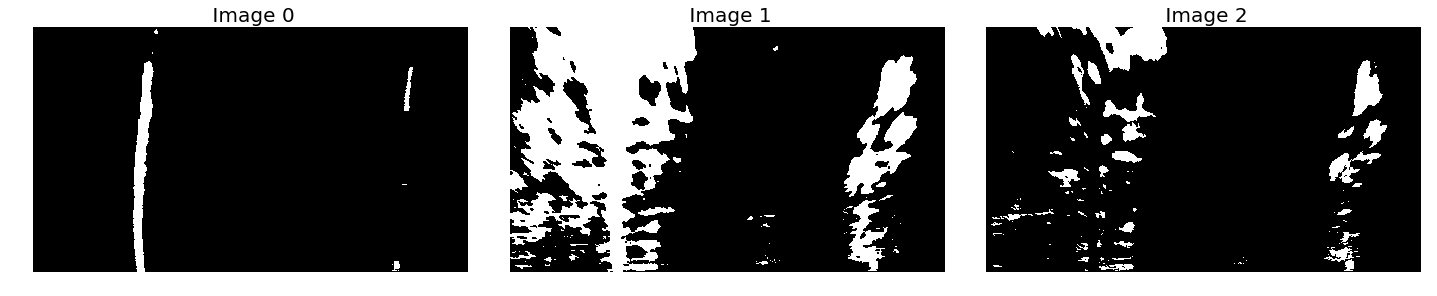

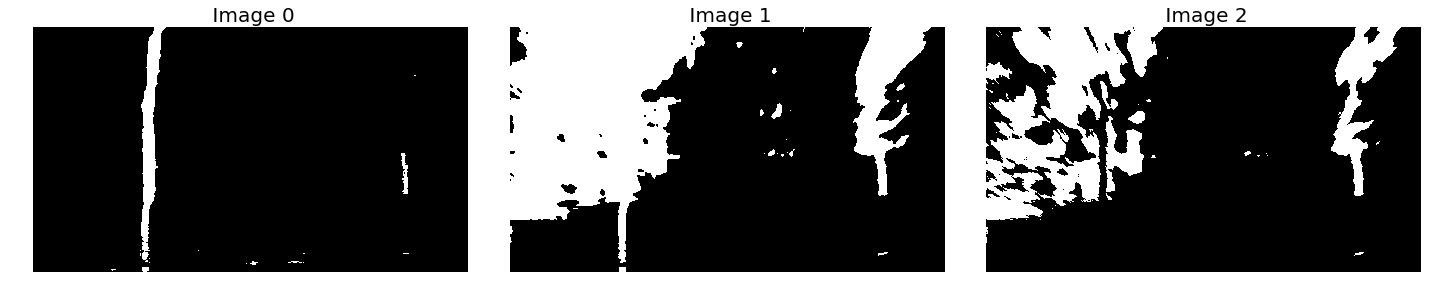

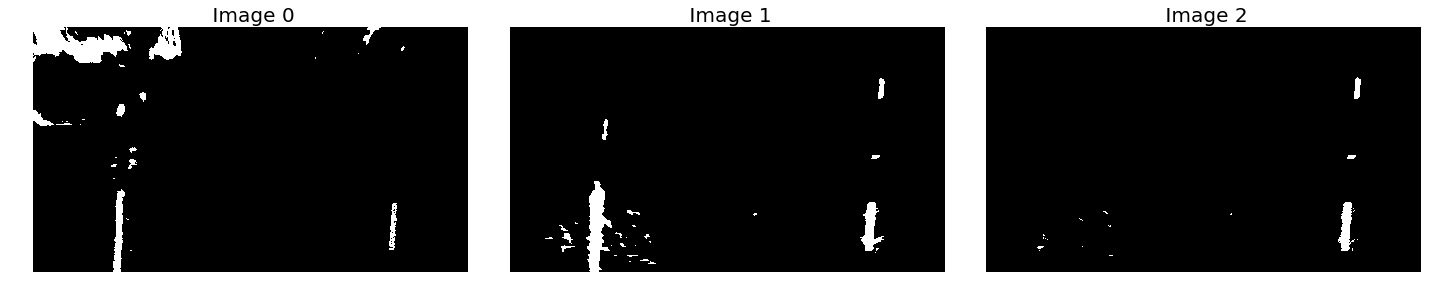

In [9]:
masks = []

for i in warped_images:
    img = get_binary_image(i, S_Min_Max.value[0], S_Min_Max.value[1],
                           V_Min_Max.value[0], V_Min_Max.value[1],
                           L_Min_Max.value[0], L_Min_Max.value[1])
    masks.append(img)
    

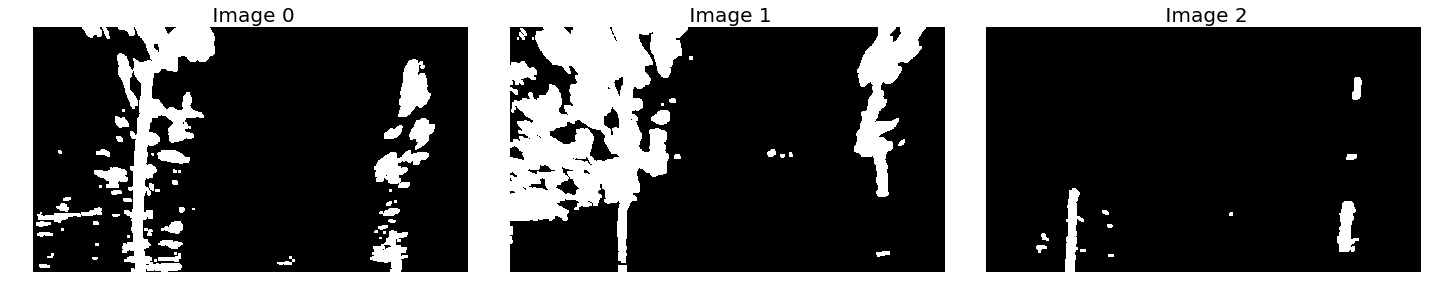

In [10]:
f, axes = plt.subplots(1, len(masks), figsize=(20,10))
f.tight_layout()

for i, img in enumerate(masks):
    img = cv2.dilate(img, small_kernel, iterations=2)
    axes[i].axis('off')
    axes[i].set_title(' Image {i}'.format(i=i), fontsize=20)
    axes[i].imshow(img, cmap='gray')

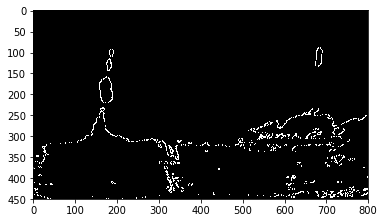

In [11]:
img = warped_images[2]


def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
    """
    Takes an image, gradient orientation, and threshold min/max values
    """
    # Convert to grayscale
    gray = combine_s_v(img)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

abs_bin = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
# mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))
# dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

# combined = np.zeros_like(dir_bin)
# combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1)))] = 1
plt.imshow(abs_bin, cmap='gray')